In [1]:
import os
import sys
import pickle as pkl
import pandas as pd
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
PROJECT_DIR = "/Users/lihangyu/Desktop/aigc"
sys.path.append(PROJECT_DIR)
from upload.load_env import load_env
load_env(f"{PROJECT_DIR}/.env")
data_path = os.environ.get('TRAIN_DATA_PATH')

已加载环境变量: PROJECT_DIR = /Users/lihangyu/Desktop/aigc
已加载环境变量: TRAIN_LOG_PATH = /Users/lihangyu/Desktop/aigc/logs
已加载环境变量: TRAIN_TF_EVENTS_PATH = /Users/lihangyu/Desktop/aigc/tensorboard_logs
已加载环境变量: TRAIN_DATA_PATH = /Users/lihangyu/Desktop/aigc/TencentGR_1k
已加载环境变量: TRAIN_CKPT_PATH = /Users/lihangyu/Desktop/aigc/checkpoints


### indexer.pkl

In [3]:
indexer = pkl.load(open(os.path.join(data_path, "indexer.pkl"), "rb"))
print(indexer.keys())

dict_keys(['f', 'i', 'u', 'a'])


In [4]:
# wuid re-id
user_indexer = indexer['u']
print('总用户数:', len(user_indexer))
print('最小wuid:', min(user_indexer))
print('最大wuid:', max(user_indexer))
print("最小wuid_re-id:", min(user_indexer.values()))
print("最大wuid_re-id:", max(user_indexer.values()))
print('最小wuid的映射:', min(user_indexer), '->', user_indexer[min(user_indexer)])
print('最大wuid的映射:', max(user_indexer), '->', user_indexer[max(user_indexer)])

总用户数: 865
最小wuid: user_00003897
最大wuid: user_01354683
最小wuid_re-id: 1
最大wuid_re-id: 865
最小wuid的映射: user_00003897 -> 468
最大wuid的映射: user_01354683 -> 624


In [5]:
# creative re-id
item_indexer = indexer['i']
print('总物品数:', len(item_indexer))
print('最小creative_id:', min(item_indexer))
print('最大creative_id:', max(item_indexer))
print("最小creative_id_re-id:", min(item_indexer.values()))
print("最大creative_id_re-id:", max(item_indexer.values()))
print('最小creative_id的映射:', min(item_indexer), '->', item_indexer[min(item_indexer)])
print('最大creative_id的映射:', max(item_indexer), '->', item_indexer[max(item_indexer)])

总物品数: 58734
最小creative_id: 20000000027
最大creative_id: 20005906211
最小creative_id_re-id: 1
最大creative_id_re-id: 58734
最小creative_id的映射: 20000000027 -> 24749
最大creative_id的映射: 20005906211 -> 57075


In [6]:
# feature re-id
feature_value_indexers = indexer['f']
print('总特征数:', len(feature_value_indexers))
print('最小feature_id:', min(feature_value_indexers))
print('最大feature_id:', max(feature_value_indexers))
# 按照feature_id排序并格式化输出
print(f'{"feature_id":<10} {"value_num":<10} {"max_value":<15} {"min_value":<15}')
for feature_id in sorted(feature_value_indexers.keys()):
    feature_value_indexer = feature_value_indexers[feature_id]
    # 打印feature_id, feature_value_indexer的key的数量，最大的key, 最小的key
    print(f"{feature_id:<10} {len(feature_value_indexer):<10} {max(feature_value_indexer):<15} {min(feature_value_indexer):<15}")

print('\nfeature_id=100对应的feature_value_indexer:')
print(feature_value_indexers['100'])

总特征数: 22
最小feature_id: 100
最大feature_id: 122
feature_id value_num  max_value       min_value      
100        6          1000000005      1000000000     
101        44         1010000050      1010000000     
102        11136      1020100454      1020000030     
103        67         1030000087      1030000000     
104        2          1040000001      1040000000     
105        7          1050000006      1050000000     
106        13         1060000013      1060000000     
107        17         1070000018      1070000000     
108        4          1080000003      1080000000     
109        3          1090000002      1090000000     
110        2          1100000001      1100000000     
111        58734      1115906655      1110000061     
112        25         1120000029      1120000000     
114        17         1140000025      1140000000     
115        187        1150000743      1150000000     
116        18         1160000017      1160000000     
117        285        1170000503     

### seq.jsonl & seq_offsets.pkl

In [7]:
# 用户行为序列的offet，偏于读取用户行为序列
with open(Path(data_path, 'seq_offsets.pkl'), 'rb') as f:
    seq_offsets = pkl.load(f)
print('seq offsets为list, 元素数量等于用户数，记录了seq.jsonl每一行用户行为序列的其实文件指针offset')
print(type(seq_offsets))
print(len(seq_offsets))
print(seq_offsets[0], seq_offsets[-1])

seq offsets为list, 元素数量等于用户数，记录了seq.jsonl每一行用户行为序列的其实文件指针offset
<class 'list'>
865
0 15114487


In [8]:
def _load_user_data(uid):
    """
    从数据文件中加载单个用户的数据

    Args:
        uid: 用户ID(reid)

    Returns:
        data: 用户序列数据，格式为[(user_id, item_id, user_feat, item_feat, action_type, timestamp)]
    """
    data_file = open(Path(data_path, 'seq.jsonl'))
    data_file.seek(seq_offsets[uid])
    line = data_file.readline()
    data = json.loads(line)
    return data

In [9]:
# 用户行为序列
user_count = len(seq_offsets)
user_seqs = []
for uid in range(user_count):
    user_seq = _load_user_data(uid)
    user_seqs.append(user_seq)

In [10]:
"""
每个用户行为序列user_seq为一个列表，每个元素为一条record
中每一条record为一个列表，格式: [user_id, item_id, user_feature, item_feature, action_type, timestamp]
有2种类型record:
    1. user profile: [user_id, None, user_feature, None, None, timestamp]
    2. item interaction: [user_id, item_id, None, item_feature, action_type, timestamp]
这里的user_id, item_id, feature_value也全部从1进行了重新编号
"""

'\n每个用户行为序列user_seq为一个列表，每个元素为一条record\n中每一条record为一个列表，格式: [user_id, item_id, user_feature, item_feature, action_type, timestamp]\n有2种类型record:\n    1. user profile: [user_id, None, user_feature, None, None, timestamp]\n    2. item interaction: [user_id, item_id, None, item_feature, action_type, timestamp]\n这里的user_id, item_id, feature_value也全部从1进行了重新编号\n'

#### 用户行为序列长度统计

In [11]:
# 存储每个用户的统计数据
user_item_interaction_counts = []
user_profile_counts = []

for user_seq in user_seqs:
    item_interaction_count = 0
    user_profile_count = 0
    
    for record in user_seq:
        user_id, item_id, user_feature, item_feature, action_type, timestamp = record
        
        # 判断记录类型
        if item_id is None and item_feature is None and action_type is None:
            # user profile: [user_id, None, user_feature, None, None, timestamp]
            user_profile_count += 1
        elif user_feature is None:
            # item interaction: [user_id, item_id, None, item_feature, action_type, timestamp]
            item_interaction_count += 1
    
    user_item_interaction_counts.append(item_interaction_count)
    user_profile_counts.append(user_profile_count)

# 计算统计指标
def calculate_stats(data, data_type):
    if not data:
        print(f"{data_type}: 无数据")
        return
    
    data = np.array(data)
    print(f"\n{data_type} 统计:")
    print(f"  总用户数: {len(data)}")
    print(f"  平均数: {np.mean(data):.2f}")
    print(f"  中位数: {np.median(data):.2f}")
    print(f"  最小值: {np.min(data)}")
    print(f"  最大值: {np.max(data)}")
    print(f"  标准差: {np.std(data):.2f}")
    print(f"  1%分位数: {np.percentile(data, 1):.2f}")
    print(f"  5%分位数: {np.percentile(data, 5):.2f}")
    print(f"  10%分位数: {np.percentile(data, 10):.2f}")
    print(f"  25%分位数: {np.percentile(data, 25):.2f}")
    print(f"  50%分位数: {np.percentile(data, 50):.2f}")
    print(f"  75%分位数: {np.percentile(data, 75):.2f}")
    print(f"  90%分位数: {np.percentile(data, 90):.2f}")
    print(f"  95%分位数: {np.percentile(data, 95):.2f}")
    print(f"  99%分位数: {np.percentile(data, 99):.2f}")

# 输出统计结果
calculate_stats(user_item_interaction_counts, "Item Interaction 数量")
calculate_stats(user_profile_counts, "User Profile 数量")

# 可选：输出详细的用户级别统计
print(f"\n详细统计:")
print(f"用户总数: {len(user_seqs)}")
print(f"有item interaction的用户数: {sum(1 for count in user_item_interaction_counts if count > 0)}")
print(f"有user profile的用户数: {sum(1 for count in user_profile_counts if count > 0)}")


Item Interaction 数量 统计:
  总用户数: 865
  平均数: 89.89
  中位数: 94.00
  最小值: 10
  最大值: 100
  标准差: 12.53
  1%分位数: 40.28
  5%分位数: 64.00
  10%分位数: 75.00
  25%分位数: 87.00
  50%分位数: 94.00
  75%分位数: 98.00
  90%分位数: 100.00
  95%分位数: 100.00
  99%分位数: 100.00

User Profile 数量 统计:
  总用户数: 865
  平均数: 1.00
  中位数: 1.00
  最小值: 1
  最大值: 1
  标准差: 0.00
  1%分位数: 1.00
  5%分位数: 1.00
  10%分位数: 1.00
  25%分位数: 1.00
  50%分位数: 1.00
  75%分位数: 1.00
  90%分位数: 1.00
  95%分位数: 1.00
  99%分位数: 1.00

详细统计:
用户总数: 865
有item interaction的用户数: 865
有user profile的用户数: 865


#### 用户行为序列格式

In [12]:
user_seq = user_seqs[0]
for record in user_seq:
    user_id, item_id, user_feature, item_feature, action_type, timestamp = record
    
    # 判断记录类型
    if item_id is None and item_feature is None and action_type is None:
        # user profile: [user_id, None, user_feature, None, None, timestamp]
        user_profile = record
    elif user_feature is None:
        # item interaction: [user_id, item_id, None, item_feature, action_type, timestamp]
        item_interaction = record

In [13]:
user_profile

[640,
 None,
 {'103': 46, '106': [4], '109': 1, '105': 5, '104': 2},
 None,
 None,
 1748049465]

In [14]:
item_interaction

[640,
 33595,
 None,
 {'112': 14,
  '117': 80,
  '118': 104,
  '119': 1737,
  '120': 118,
  '121': 7939,
  '100': 6,
  '101': 9,
  '102': 8595,
  '122': 8176,
  '111': 35058,
  '114': 16,
  '116': 1},
 0,
 1748000648]

#### 用户行为序列时间跨度分析


In [15]:
# 存储所有用户的统计信息
user_stats = []
all_spans = []
all_intervals = []

# 遍历每个用户
for user_seq in user_seqs:
    item_interactions = []
    # 遍历user_seq，找到交互过的item
    for record in user_seq:
        user_id, item_id, user_feature, item_feature, action_type, timestamp = record
        if user_feature is None:
            # item interaction: [user_id, item_id, None, item_feature, action_type, timestamp]
            item_interactions.append(record)
    
    # 如果该用户有交互记录
    if len(item_interactions) > 0:
        # 提取时间戳并排序
        timestamps = [record[5] for record in item_interactions]
        timestamps.sort()
        
        user_id = item_interactions[0][0]  # 获取用户ID
        
        # 计算时间跨度（秒）
        if len(timestamps) > 1:
            span_seconds = timestamps[-1] - timestamps[0]
            span_hours = span_seconds / 3600
            span_days = span_seconds / (3600 * 24)
        else:
            span_seconds = span_hours = span_days = 0
        
        # 计算时间间隔（秒）
        intervals_seconds = []
        intervals_hours = []
        if len(timestamps) > 1:
            for i in range(1, len(timestamps)):
                interval_sec = timestamps[i] - timestamps[i-1]
                intervals_seconds.append(interval_sec)
                intervals_hours.append(interval_sec / 3600)
        
        # 统计该用户的信息
        user_stat = {
            'user_id': user_id,
            'interaction_count': len(item_interactions),
            'span_seconds': span_seconds,
            'span_hours': span_hours,
            'span_days': span_days,
            'avg_interval_seconds': np.mean(intervals_seconds) if intervals_seconds else 0,
            'avg_interval_hours': np.mean(intervals_hours) if intervals_hours else 0,
            'median_interval_seconds': np.median(intervals_seconds) if intervals_seconds else 0,
            'min_interval_seconds': np.min(intervals_seconds) if intervals_seconds else 0,
            'max_interval_seconds': np.max(intervals_seconds) if intervals_seconds else 0,
            'std_interval_seconds': np.std(intervals_seconds) if intervals_seconds else 0
        }
        
        user_stats.append(user_stat)
        all_spans.extend([span_seconds])
        all_intervals.extend(intervals_seconds)

# 计算全局统计量
print("=== 全局统计 ===")
print(f"总用户数: {len(user_stats)}")
print(f"总交互次数: {sum([stat['interaction_count'] for stat in user_stats])}")

if all_spans:
    print("\n--- 时间跨度统计 (秒) ---")
    print(f"均值: {np.mean(all_spans):.2f}")
    print(f"中位数: {np.median(all_spans):.2f}")
    print(f"25%分位数: {np.percentile(all_spans, 25):.2f}")
    print(f"75%分位数: {np.percentile(all_spans, 75):.2f}")
    print(f"最小值: {np.min(all_spans):.2f}")
    print(f"最大值: {np.max(all_spans):.2f}")
    print(f"标准差: {np.std(all_spans):.2f}")

if all_intervals:
    print("\n--- 交互间隔统计 (秒) ---")
    print(f"均值: {np.mean(all_intervals):.2f}")
    print(f"中位数: {np.median(all_intervals):.2f}")
    print(f"25%分位数: {np.percentile(all_intervals, 25):.2f}")
    print(f"75%分位数: {np.percentile(all_intervals, 75):.2f}")
    print(f"最小值: {np.min(all_intervals):.2f}")
    print(f"最大值: {np.max(all_intervals):.2f}")
    print(f"标准差: {np.std(all_intervals):.2f}")
    
    print("\n--- 交互间隔统计 (小时) ---")
    intervals_hours_all = [x/3600 for x in all_intervals]
    print(f"均值: {np.mean(intervals_hours_all):.2f}")
    print(f"中位数: {np.median(intervals_hours_all):.2f}")
    print(f"25%分位数: {np.percentile(intervals_hours_all, 25):.2f}")
    print(f"75%分位数: {np.percentile(intervals_hours_all, 75):.2f}")

# 将结果转换为DataFrame便于进一步分析
user_stats_df = pd.DataFrame(user_stats)
print("\n=== 用户级别统计摘要 ===")
print(user_stats_df.describe())

# 可选：保存结果
# user_stats_df.to_csv('user_interaction_stats.csv', index=False)

=== 全局统计 ===
总用户数: 865
总交互次数: 77756

--- 时间跨度统计 (秒) ---
均值: 3178004.67
中位数: 2247587.00
25%分位数: 1515690.00
75%分位数: 3504793.00
最小值: 579640.00
最大值: 19028744.00
标准差: 2944270.03

--- 交互间隔统计 (秒) ---
均值: 35751.57
中位数: 6392.00
25%分位数: 746.00
75%分位数: 40806.00
最小值: 0.00
最大值: 11898871.00
标准差: 138733.73

--- 交互间隔统计 (小时) ---
均值: 9.93
中位数: 1.78
25%分位数: 0.21
75%分位数: 11.34

=== 用户级别统计摘要 ===
          user_id  interaction_count  span_seconds   span_hours   span_days  \
count  865.000000         865.000000  8.650000e+02   865.000000  865.000000   
mean   433.000000          89.891329  3.178005e+06   882.779074   36.782461   
std    249.848287          12.539649  2.945973e+06   818.325945   34.096914   
min      1.000000          10.000000  5.796400e+05   161.011111    6.708796   
25%    217.000000          87.000000  1.515690e+06   421.025000   17.542708   
50%    433.000000          94.000000  2.247587e+06   624.329722   26.013738   
75%    649.000000          98.000000  3.504793e+06   973.553611   40.

#### 用户行为序列时间分布

In [16]:
import datetime
import pandas as pd
from collections import defaultdict
import numpy as np

# 存储所有时间戳用于时间段分析
all_timestamps = []

# 遍历每个用户，收集所有交互时间戳
for user_seq in user_seqs:
    item_interactions = []
    # 遍历user_seq，找到交互过的item
    for record in user_seq:
        user_id, item_id, user_feature, item_feature, action_type, timestamp = record
        if user_feature is None:
            # item interaction: [user_id, item_id, None, item_feature, action_type, timestamp]
            item_interactions.append(record)
    
    # 如果该用户有交互记录，收集时间戳
    if len(item_interactions) > 0:
        timestamps = [record[5] for record in item_interactions]
        all_timestamps.extend(timestamps)

# === 增强版时间段统计分析 ===
if all_timestamps:
    print("=== 详细时间段统计分析 ===")
    
    # 全局统计
    global_hour_counts = defaultdict(int)
    global_weekday_counts = defaultdict(int)
    global_date_counts = defaultdict(int)
    
    # 每日各时段统计 (weekday + hour)
    weekday_hour_counts = defaultdict(lambda: defaultdict(int))
    
    for ts in all_timestamps:
        dt = datetime.datetime.fromtimestamp(ts)
        global_hour_counts[dt.hour] += 1
        global_weekday_counts[dt.weekday()] += 1
        global_date_counts[dt.date()] += 1
        
        # 记录每个星期几的每个小时的交互量
        weekday_hour_counts[dt.weekday()][dt.hour] += 1
    
    total_interactions = len(all_timestamps)
    
    print("\n--- 每日时间段分布 (按小时) ---")
    for hour in range(24):
        count = global_hour_counts[hour]
        percentage = (count / total_interactions) * 100 if total_interactions > 0 else 0
        # 添加时段标识
        if 6 <= hour < 12:
            period = "上午"
        elif 12 <= hour < 14:
            period = "中午"
        elif 14 <= hour < 18:
            period = "下午"
        elif 18 <= hour < 22:
            period = "晚上"
        else:
            period = "深夜"
        
        print(f"{hour:02d}:00-{hour:02d}:59 ({period}): {count:6d} 次 ({percentage:5.2f}%)")
    
    print("\n--- 每周时间段分布 (按星期) ---")
    weekdays = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
    for day_idx in range(7):
        count = global_weekday_counts[day_idx]
        percentage = (count / total_interactions) * 100 if total_interactions > 0 else 0
        print(f"{weekdays[day_idx]}: {count:6d} 次 ({percentage:5.2f}%)")
    
    # === 新增：每日各时段详细分析 ===
    print("\n--- 每日各时段详细分析 ---")
    
    # 创建热力图数据
    heatmap_data = []
    for day_idx in range(7):
        day_data = []
        for hour in range(24):
            count = weekday_hour_counts[day_idx][hour]
            day_data.append(count)
        heatmap_data.append(day_data)
    
    # 显示每日各时段的交互量
    print("\n时间段热力图 (行:星期, 列:小时):")
    print("     ", end="")
    for hour in range(24):
        print(f"{hour:2d}", end=" ")
    print()
    
    for day_idx in range(7):
        print(f"{weekdays[day_idx][:2]} ", end="")
        for hour in range(24):
            count = weekday_hour_counts[day_idx][hour]
            if count == 0:
                print(" .", end=" ")
            elif count < 10:
                print(f"{count:2d}", end=" ")
            else:
                print(f"{count:2d}", end=" ")
        print()
    
    # 找出每日的活跃时段
    print("\n--- 每日活跃时段分析 ---")
    for day_idx in range(7):
        day_counts = weekday_hour_counts[day_idx]
        if day_counts:
            # 找出该日最活跃的3个时段
            top_hours = sorted(day_counts.items(), key=lambda x: x[1], reverse=True)[:3]
            print(f"{weekdays[day_idx]}:")
            for i, (hour, count) in enumerate(top_hours, 1):
                if count > 0:
                    percentage = (count / global_weekday_counts[day_idx]) * 100
                    print(f"  {i}. {hour:02d}:00-{hour:02d}:59: {count} 次 ({percentage:.1f}%)")
        print()
    
    # === 时段分类统计 ===
    print("--- 时段分类统计 ---")
    
    # 定义时段
    time_periods = {
        '深夜': list(range(0, 6)),      # 00:00-05:59
        '上午': list(range(6, 12)),     # 06:00-11:59
        '中午': list(range(12, 14)),    # 12:00-13:59
        '下午': list(range(14, 18)),    # 14:00-17:59
        '晚上': list(range(18, 22)),    # 18:00-21:59
        '深夜晚': list(range(22, 24))   # 22:00-23:59
    }
    
    period_counts = {}
    for period_name, hours in time_periods.items():
        count = sum(global_hour_counts[hour] for hour in hours)
        period_counts[period_name] = count
        percentage = (count / total_interactions) * 100
        print(f"{period_name}: {count:6d} 次 ({percentage:5.2f}%)")
    
    # 合并深夜时段
    night_total = period_counts['深夜'] + period_counts['深夜晚']
    print(f"深夜合计: {night_total:6d} 次 ({night_total/total_interactions*100:5.2f}%)")
    
    # === 工作日vs周末的详细分析 ===
    print("\n--- 工作日 vs 周末详细分析 ---")
    
    weekday_total = sum(global_weekday_counts[i] for i in range(5))
    weekend_total = sum(global_weekday_counts[i] for i in range(5, 7))
    
    print(f"工作日 (周一-周五): {weekday_total:6d} 次 ({weekday_total/total_interactions*100:5.2f}%)")
    print(f"周末 (周六-周日): {weekend_total:6d} 次 ({weekend_total/total_interactions*100:5.2f}%)")
    
    # 工作日和周末的时段偏好
    print("\n工作日时段分布:")
    weekday_hour_total = defaultdict(int)
    weekend_hour_total = defaultdict(int)
    
    for day_idx in range(5):  # 工作日
        for hour in range(24):
            weekday_hour_total[hour] += weekday_hour_counts[day_idx][hour]
    
    for day_idx in range(5, 7):  # 周末
        for hour in range(24):
            weekend_hour_total[hour] += weekday_hour_counts[day_idx][hour]
    
    for hour in range(24):
        wd_count = weekday_hour_total[hour]
        we_count = weekend_hour_total[hour]
        wd_pct = (wd_count / weekday_total * 100) if weekday_total > 0 else 0
        we_pct = (we_count / weekend_total * 100) if weekend_total > 0 else 0
        print(f"{hour:02d}:00: 工作日 {wd_count:4d}次({wd_pct:4.1f}%) | 周末 {we_count:4d}次({we_pct:4.1f}%)")
    
    # === 找出异常时段 ===
    print("\n--- 异常时段识别 ---")
    
    # 计算每小时的平均交互量
    avg_hourly = total_interactions / 24
    
    # 找出明显高于或低于平均值的时段
    high_activity_hours = []
    low_activity_hours = []
    
    for hour in range(24):
        count = global_hour_counts[hour]
        if count > avg_hourly * 1.5:  # 高于平均值50%
            high_activity_hours.append((hour, count))
        elif count < avg_hourly * 0.5:  # 低于平均值50%
            low_activity_hours.append((hour, count))
    
    if high_activity_hours:
        print("高活跃时段 (超过平均值50%):")
        for hour, count in high_activity_hours:
            print(f"  {hour:02d}:00-{hour:02d}:59: {count} 次")
    
    if low_activity_hours:
        print("低活跃时段 (低于平均值50%):")
        for hour, count in low_activity_hours:
            print(f"  {hour:02d}:00-{hour:02d}:59: {count} 次")
    
    # === 创建详细的统计DataFrame ===
    
    # 小时统计
    hour_stats = pd.DataFrame([
        {
            'hour': hour, 
            'count': global_hour_counts[hour], 
            'percentage': global_hour_counts[hour]/total_interactions*100,
            'period': '深夜' if hour < 6 or hour >= 22 else 
                     '上午' if 6 <= hour < 12 else
                     '中午' if 12 <= hour < 14 else
                     '下午' if 14 <= hour < 18 else '晚上'
        }
        for hour in range(24)
    ])
    
    # 星期统计
    weekday_stats = pd.DataFrame([
        {
            'weekday': weekdays[day], 
            'weekday_num': day, 
            'count': global_weekday_counts[day],
            'percentage': global_weekday_counts[day]/total_interactions*100,
            'type': '工作日' if day < 5 else '周末'
        }
        for day in range(7)
    ])
    
    # 每日每小时统计 (用于热力图)
    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=weekdays, 
                             columns=[f"{h:02d}:00" for h in range(24)])
    
    print(f"\n--- 统计摘要 ---")
    print(f"总交互次数: {total_interactions:,}")
    print(f"分析时间跨度: {min(all_timestamps)} - {max(all_timestamps)}")
    print(f"涉及日期数: {len(global_date_counts)}")
    print(f"日均交互量: {total_interactions/len(global_date_counts):.1f}")
    
    # 保存统计结果 (可选)
    # hour_stats.to_csv('detailed_hourly_stats.csv', index=False)
    # weekday_stats.to_csv('detailed_weekday_stats.csv', index=False)
    # heatmap_df.to_csv('weekday_hour_heatmap.csv')
    
    print("\n=== 时间段分析完成 ===")

# === 可视化建议 ===
print("\n=== 可视化建议 ===")
print("1. 使用 seaborn.heatmap() 绘制星期-小时热力图")
print("2. 使用 matplotlib 绘制24小时活跃度曲线")
print("3. 使用柱状图对比工作日vs周末的时段分布")
print("4. 使用极坐标图展示24小时周期性模式")


=== 详细时间段统计分析 ===

--- 每日时间段分布 (按小时) ---
00:00-00:59 (深夜):   2086 次 ( 2.68%)
01:00-01:59 (深夜):   1024 次 ( 1.32%)
02:00-02:59 (深夜):    652 次 ( 0.84%)
03:00-03:59 (深夜):    652 次 ( 0.84%)
04:00-04:59 (深夜):    902 次 ( 1.16%)
05:00-05:59 (深夜):   1905 次 ( 2.45%)
06:00-06:59 (上午):   3501 次 ( 4.50%)
07:00-07:59 (上午):   4495 次 ( 5.78%)
08:00-08:59 (上午):   4927 次 ( 6.34%)
09:00-09:59 (上午):   4840 次 ( 6.22%)
10:00-10:59 (上午):   4599 次 ( 5.91%)
11:00-11:59 (上午):   4686 次 ( 6.03%)
12:00-12:59 (中午):   4885 次 ( 6.28%)
13:00-13:59 (中午):   4280 次 ( 5.50%)
14:00-14:59 (下午):   3744 次 ( 4.82%)
15:00-15:59 (下午):   3511 次 ( 4.52%)
16:00-16:59 (下午):   3382 次 ( 4.35%)
17:00-17:59 (下午):   3465 次 ( 4.46%)
18:00-18:59 (晚上):   3727 次 ( 4.79%)
19:00-19:59 (晚上):   3712 次 ( 4.77%)
20:00-20:59 (晚上):   3940 次 ( 5.07%)
21:00-21:59 (晚上):   3753 次 ( 4.83%)
22:00-22:59 (深夜):   3178 次 ( 4.09%)
23:00-23:59 (深夜):   1910 次 ( 2.46%)

--- 每周时间段分布 (按星期) ---
周一:  11027 次 (14.18%)
周二:  11115 次 (14.29%)
周三:  11408 次 (14.67%)
周四:  1

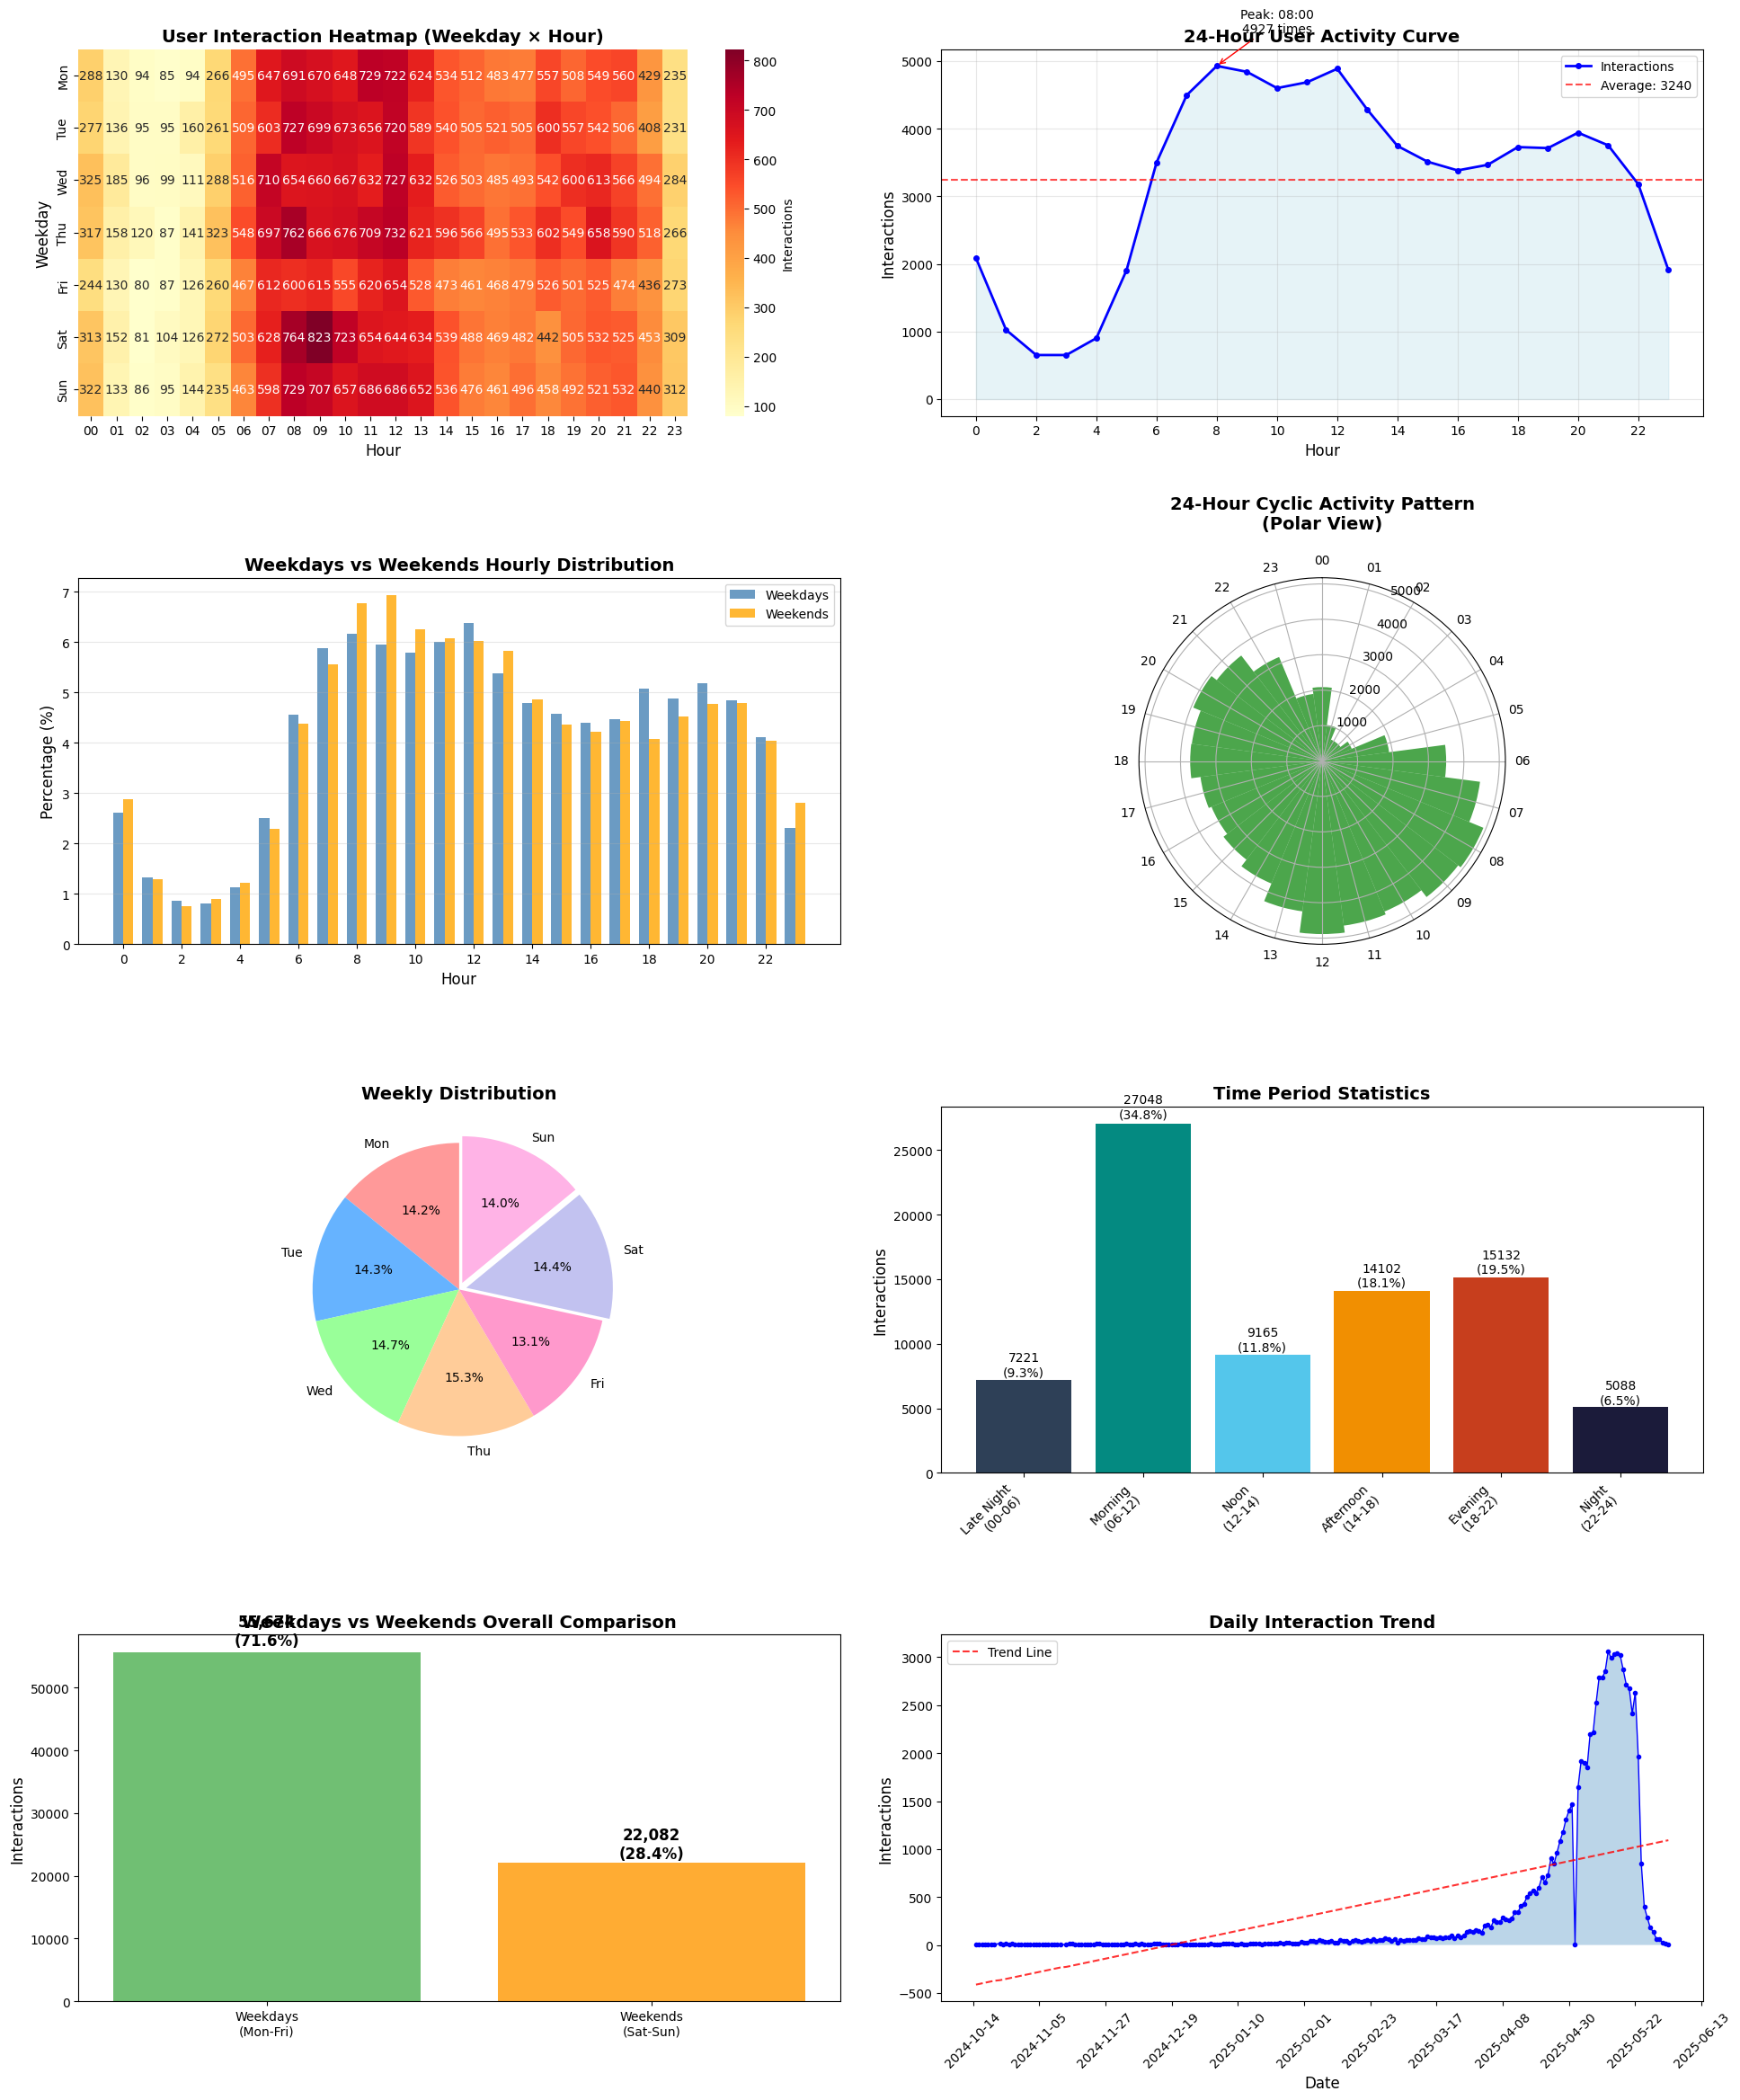


=== Generating Additional Analysis Charts ===


/var/folders/k6/h0tmlbzj09lg5twn9ctkrz540000gn/T/ipykernel_85566/1756558497.py:235: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax9.boxplot(daily_distributions, labels=labels, patch_artist=True)


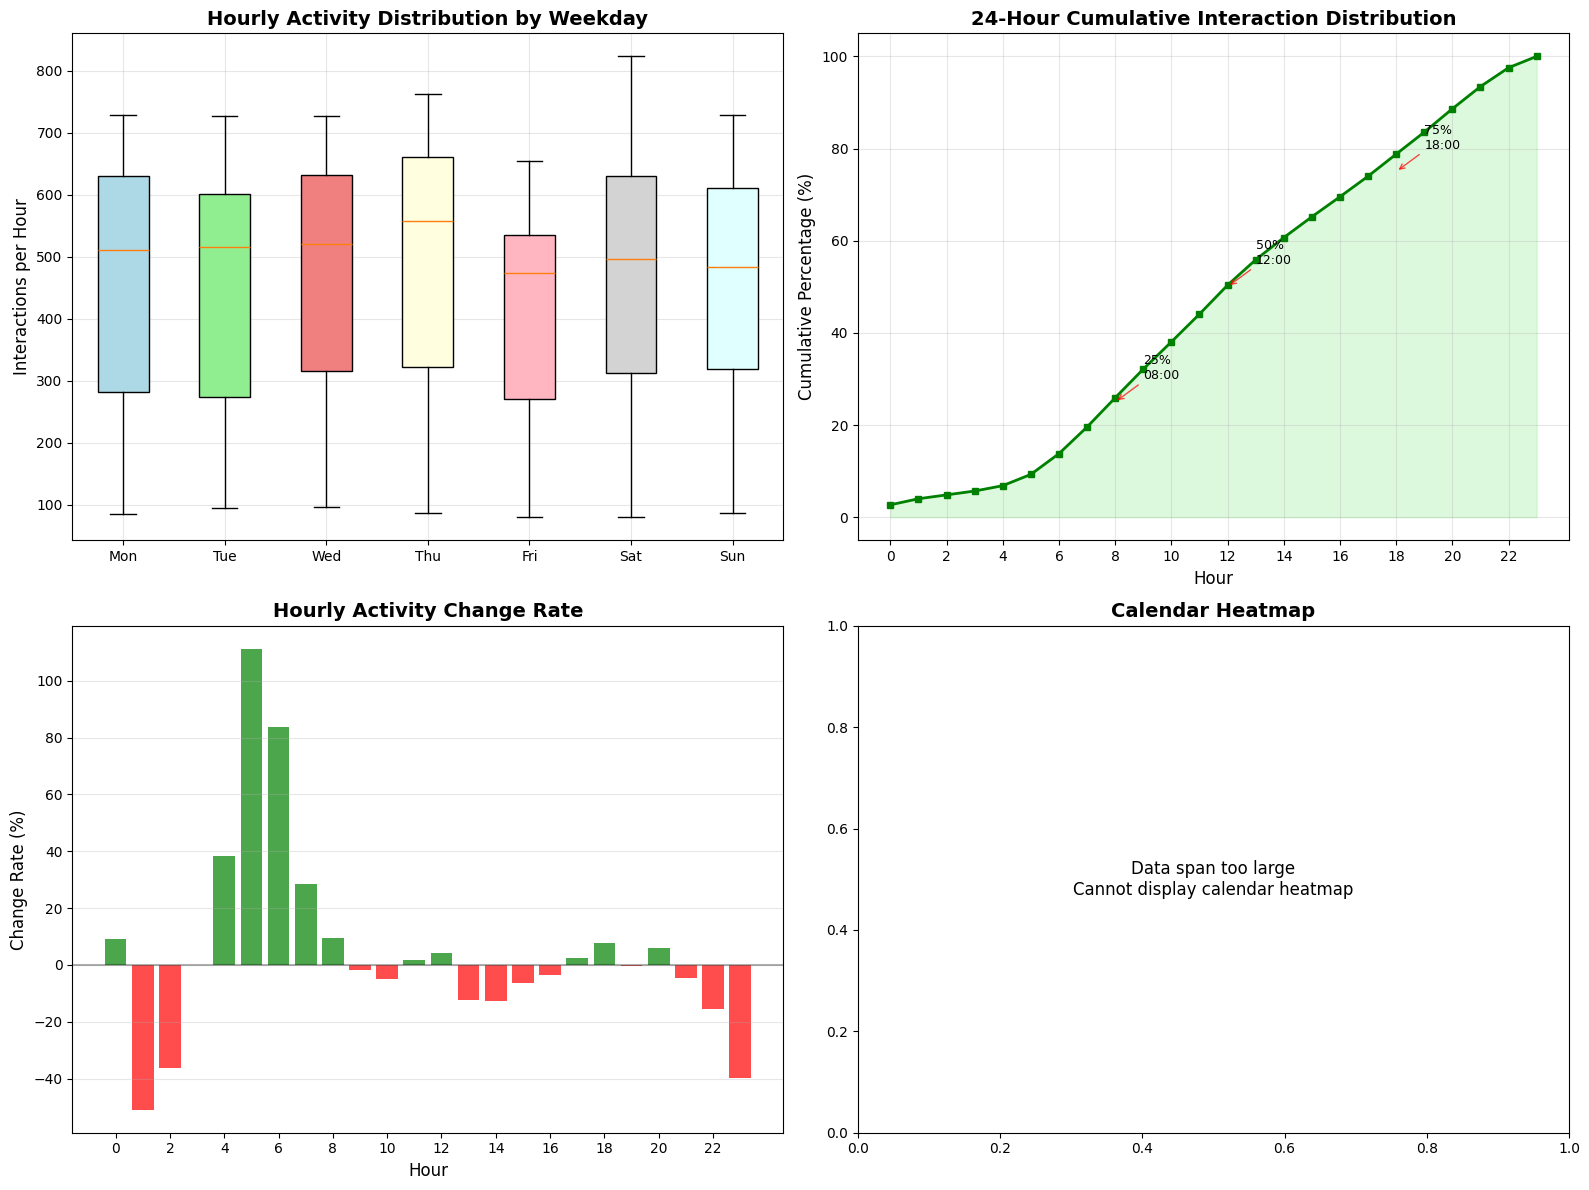


=== Chart Saving Options ===
To save charts, uncomment the following lines:
# fig.savefig('user_interaction_analysis.png', dpi=300, bbox_inches='tight')
# fig2.savefig('additional_analysis.png', dpi=300, bbox_inches='tight')

=== Visualization Analysis Summary ===
1. Heatmap shows spatial-temporal distribution of user interactions
2. 24-hour curve reveals cyclical patterns of user activity
3. Weekday vs weekend comparison shows usage preferences
4. Polar chart intuitively displays 24-hour cyclical patterns
5. Time period statistics help understand user behavior in different periods
6. Cumulative distribution shows concentration of user activity
7. Change rate chart identifies turning points in activity
8. Calendar heatmap (if applicable) shows long-term trends

=== Key Insights ===
• Most active time: 08:00-08:59 (4927 interactions)
• Most active weekday: Thursday (11930 interactions)
• Weekday ratio: 71.6%
• Weekend ratio: 28.4%
• High activity hours: 16 hours (06, 07, 08, 09, 10...)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Circle
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Set font configuration for English
plt.rcParams['font.sans-serif'] = ['Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# English labels
weekdays_display = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays_short = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Create figure layout
fig = plt.figure(figsize=(20, 24))

# === 1. Weekday-Hour Heatmap ===
ax1 = plt.subplot(4, 2, 1)

# Prepare heatmap data
heatmap_data = np.array([[weekday_hour_counts[day][hour] for hour in range(24)] for day in range(7)])

# Draw heatmap
sns.heatmap(heatmap_data, 
            xticklabels=[f'{h:02d}' for h in range(24)],
            yticklabels=weekdays_short,
            annot=True, 
            fmt='d', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Interactions'},
            ax=ax1)

ax1.set_title('User Interaction Heatmap (Weekday × Hour)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_ylabel('Weekday', fontsize=12)

# === 2. 24-Hour Activity Curve ===
ax2 = plt.subplot(4, 2, 2)

hours = list(range(24))
counts = [global_hour_counts[h] for h in hours]

# Draw main curve
ax2.plot(hours, counts, 'b-', linewidth=2, marker='o', markersize=4, label='Interactions')
ax2.fill_between(hours, counts, alpha=0.3, color='lightblue')

# Add average line
avg_count = np.mean(counts)
ax2.axhline(y=avg_count, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_count:.0f}')

# Annotate peak
max_hour = hours[np.argmax(counts)]
max_count = max(counts)
ax2.annotate(f'Peak: {max_hour:02d}:00\n{max_count} times', 
             xy=(max_hour, max_count), 
             xytext=(max_hour+2, max_count+max_count*0.1),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, ha='center')

ax2.set_title('24-Hour User Activity Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hour', fontsize=12)
ax2.set_ylabel('Interactions', fontsize=12)
ax2.set_xticks(range(0, 24, 2))
ax2.grid(True, alpha=0.3)
ax2.legend()

# === 3. Weekdays vs Weekends Hourly Comparison ===
ax3 = plt.subplot(4, 2, 3)

# Calculate weekday and weekend hourly data
weekday_hourly = [sum(weekday_hour_counts[day][hour] for day in range(5)) for hour in range(24)]
weekend_hourly = [sum(weekday_hour_counts[day][hour] for day in range(5, 7)) for hour in range(24)]

# Normalize to percentages
weekday_total = sum(weekday_hourly)
weekend_total = sum(weekend_hourly)
weekday_pct = [x/weekday_total*100 for x in weekday_hourly]
weekend_pct = [x/weekend_total*100 for x in weekend_hourly]

x = np.arange(24)
width = 0.35

bars1 = ax3.bar(x - width/2, weekday_pct, width, label='Weekdays', color='steelblue', alpha=0.8)
bars2 = ax3.bar(x + width/2, weekend_pct, width, label='Weekends', color='orange', alpha=0.8)

ax3.set_title('Weekdays vs Weekends Hourly Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour', fontsize=12)
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.set_xticks(range(0, 24, 2))
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# === 4. Polar 24-Hour Cycle Chart ===
ax4 = plt.subplot(4, 2, 4, projection='polar')

# Convert to polar coordinates
theta = np.linspace(0, 2*np.pi, 24, endpoint=False)
radii = [global_hour_counts[h] for h in range(24)]

# Draw polar chart
bars = ax4.bar(theta, radii, width=2*np.pi/24, alpha=0.7, color='green')

# Set labels
ax4.set_theta_zero_location('N')  # 12 o'clock as 0
ax4.set_theta_direction(-1)  # Clockwise
ax4.set_thetagrids(range(0, 360, 15), 
                   labels=[f'{h:02d}' for h in range(0, 24, 1)])

ax4.set_title('24-Hour Cyclic Activity Pattern\n(Polar View)', fontsize=14, fontweight='bold', pad=20)

# === 5. Weekly Distribution Pie Chart ===
ax5 = plt.subplot(4, 2, 5)

weekday_counts = [global_weekday_counts[i] for i in range(7)]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0', '#ffb3e6']

wedges, texts, autotexts = ax5.pie(weekday_counts, 
                                   labels=weekdays_short,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   explode=[0.05 if i in [5,6] else 0 for i in range(7)])

ax5.set_title('Weekly Distribution', fontsize=14, fontweight='bold')

# === 6. Time Period Classification Bar Chart ===
ax6 = plt.subplot(4, 2, 6)

time_periods = {
    'Late Night\n(00-06)': list(range(0, 6)),
    'Morning\n(06-12)': list(range(6, 12)),
    'Noon\n(12-14)': list(range(12, 14)),
    'Afternoon\n(14-18)': list(range(14, 18)),
    'Evening\n(18-22)': list(range(18, 22)),
    'Night\n(22-24)': list(range(22, 24))
}

period_names = list(time_periods.keys())
period_counts = []
for hours in time_periods.values():
    count = sum(global_hour_counts[hour] for hour in hours)
    period_counts.append(count)

bars = ax6.bar(period_names, period_counts, 
               color=['#2E4057', '#048A81', '#54C6EB', '#F18F01', '#C73E1D', '#1B1B3A'])

# Add value labels
for bar, count in zip(bars, period_counts):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count}\n({count/total_interactions*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

ax6.set_title('Time Period Statistics', fontsize=14, fontweight='bold')
ax6.set_ylabel('Interactions', fontsize=12)
plt.setp(ax6.get_xticklabels(), rotation=45, ha='right')

# === 7. Weekdays vs Weekends Overall Comparison ===
ax7 = plt.subplot(4, 2, 7)

weekday_total = sum(global_weekday_counts[i] for i in range(5))
weekend_total = sum(global_weekday_counts[i] for i in range(5, 7))

categories = ['Weekdays\n(Mon-Fri)', 'Weekends\n(Sat-Sun)']
values = [weekday_total, weekend_total]
colors = ['#4CAF50', '#FF9800']

bars = ax7.bar(categories, values, color=colors, alpha=0.8)

# Add percentage labels
for bar, value in zip(bars, values):
    height = bar.get_height()
    percentage = value / total_interactions * 100
    ax7.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:,}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax7.set_title('Weekdays vs Weekends Overall Comparison', fontsize=14, fontweight='bold')
ax7.set_ylabel('Interactions', fontsize=12)

# === 8. Time Trend Analysis ===
ax8 = plt.subplot(4, 2, 8)

if len(global_date_counts) > 1:
    # Sort by date
    sorted_dates = sorted(global_date_counts.keys())
    daily_counts = [global_date_counts[date] for date in sorted_dates]
    
    ax8.plot(sorted_dates, daily_counts, 'b-', marker='o', markersize=3, linewidth=1)
    ax8.fill_between(sorted_dates, daily_counts, alpha=0.3)
    
    # Add trend line
    if len(daily_counts) > 2:
        z = np.polyfit(range(len(daily_counts)), daily_counts, 1)
        p = np.poly1d(z)
        ax8.plot(sorted_dates, p(range(len(daily_counts))), "r--", alpha=0.8, label='Trend Line')
        ax8.legend()
    
    ax8.set_title('Daily Interaction Trend', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Date', fontsize=12)
    ax8.set_ylabel('Interactions', fontsize=12)
    
    # Format x-axis dates
    ax8.tick_params(axis='x', rotation=45)
    if len(sorted_dates) > 10:
        ax8.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(sorted_dates)//10)))
    
else:
    ax8.text(0.5, 0.5, 'Insufficient data span\nCannot display time trend', 
             ha='center', va='center', transform=ax8.transAxes, fontsize=12)
    ax8.set_title('Daily Interaction Trend', fontsize=14, fontweight='bold')

plt.tight_layout(pad=3.0)
plt.show()

# === Additional Interactive Analysis Charts ===
print("\n=== Generating Additional Analysis Charts ===")

# === Activity Distribution Box Plots ===
fig2, ((ax9, ax10), (ax11, ax12)) = plt.subplots(2, 2, figsize=(16, 12))

# 9. Daily Activity Distribution Box Plot
daily_distributions = []
labels = []
for day in range(7):
    day_hours = [weekday_hour_counts[day][hour] for hour in range(24)]
    if sum(day_hours) > 0:  # Only include days with data
        daily_distributions.append(day_hours)
        labels.append(weekdays_short[day])

if daily_distributions:
    box_plot = ax9.boxplot(daily_distributions, labels=labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 
              'lightpink', 'lightgray', 'lightcyan']
    for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
        patch.set_facecolor(color)

ax9.set_title('Hourly Activity Distribution by Weekday', fontsize=14, fontweight='bold')
ax9.set_ylabel('Interactions per Hour', fontsize=12)
ax9.grid(True, alpha=0.3)

# 10. Cumulative Distribution Chart
ax10.set_title('24-Hour Cumulative Interaction Distribution', fontsize=14, fontweight='bold')
cumulative_counts = np.cumsum([global_hour_counts[h] for h in range(24)])
cumulative_pct = cumulative_counts / total_interactions * 100

ax10.plot(range(24), cumulative_pct, 'g-', marker='s', markersize=4, linewidth=2)
ax10.fill_between(range(24), cumulative_pct, alpha=0.3, color='lightgreen')
ax10.set_xlabel('Hour', fontsize=12)
ax10.set_ylabel('Cumulative Percentage (%)', fontsize=12)
ax10.set_xticks(range(0, 24, 2))
ax10.grid(True, alpha=0.3)

# Add milestone annotations
for milestone in [25, 50, 75]:
    idx = np.where(cumulative_pct >= milestone)[0]
    if len(idx) > 0:
        hour = idx[0]
        ax10.annotate(f'{milestone}%\n{hour:02d}:00', 
                     xy=(hour, milestone), 
                     xytext=(hour+1, milestone+5),
                     arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                     fontsize=9)

# 11. Activity Change Rate
ax11.set_title('Hourly Activity Change Rate', fontsize=14, fontweight='bold')
hourly_counts = [global_hour_counts[h] for h in range(24)]
change_rates = []
for i in range(24):
    prev_hour = (i - 1) % 24
    if hourly_counts[prev_hour] > 0:
        rate = (hourly_counts[i] - hourly_counts[prev_hour]) / hourly_counts[prev_hour] * 100
    else:
        rate = 0
    change_rates.append(rate)

colors = ['red' if x < 0 else 'green' for x in change_rates]
bars = ax11.bar(range(24), change_rates, color=colors, alpha=0.7)
ax11.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax11.set_xlabel('Hour', fontsize=12)
ax11.set_ylabel('Change Rate (%)', fontsize=12)
ax11.set_xticks(range(0, 24, 2))
ax11.grid(True, alpha=0.3, axis='y')

# 12. Activity Calendar Heatmap
if len(global_date_counts) >= 7:
    # Create calendar heatmap data
    sorted_dates = sorted(global_date_counts.keys())
    start_date = sorted_dates[0]
    end_date = sorted_dates[-1]
    
    # Calculate weeks
    date_range = (end_date - start_date).days + 1
    weeks = (date_range + start_date.weekday()) // 7 + 1
    
    if weeks <= 10:  # Only display within reasonable range
        calendar_data = np.zeros((weeks, 7))
        
        current_date = start_date - timedelta(days=start_date.weekday())
        for week in range(weeks):
            for day in range(7):
                if current_date in global_date_counts:
                    calendar_data[week, day] = global_date_counts[current_date]
                current_date += timedelta(days=1)
        
        im = ax12.imshow(calendar_data, cmap='YlOrRd', aspect='auto')
        ax12.set_title('Calendar Heatmap', fontsize=14, fontweight='bold')
        ax12.set_xlabel('Weekday', fontsize=12)
        ax12.set_ylabel('Week', fontsize=12)
        ax12.set_xticks(range(7))
        ax12.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'])
        
        # Add colorbar
        plt.colorbar(im, ax=ax12, label='Interactions')
    else:
        ax12.text(0.5, 0.5, 'Data span too large\nCannot display calendar heatmap', 
                 ha='center', va='center', transform=ax12.transAxes, fontsize=12)
        ax12.set_title('Calendar Heatmap', fontsize=14, fontweight='bold')
else:
    ax12.text(0.5, 0.5, 'Insufficient data span\nCannot display calendar heatmap', 
             ha='center', va='center', transform=ax12.transAxes, fontsize=12)
    ax12.set_title('Calendar Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# === Chart Saving Options ===
print("\n=== Chart Saving Options ===")
print("To save charts, uncomment the following lines:")
print("# fig.savefig('user_interaction_analysis.png', dpi=300, bbox_inches='tight')")
print("# fig2.savefig('additional_analysis.png', dpi=300, bbox_inches='tight')")

# === Generate Analysis Report ===
print("\n=== Visualization Analysis Summary ===")
print("1. Heatmap shows spatial-temporal distribution of user interactions")
print("2. 24-hour curve reveals cyclical patterns of user activity")
print("3. Weekday vs weekend comparison shows usage preferences")
print("4. Polar chart intuitively displays 24-hour cyclical patterns")
print("5. Time period statistics help understand user behavior in different periods")
print("6. Cumulative distribution shows concentration of user activity")
print("7. Change rate chart identifies turning points in activity")
print("8. Calendar heatmap (if applicable) shows long-term trends")

# Generate key insights
peak_hour = max(global_hour_counts.items(), key=lambda x: x[1])
peak_day = max(global_weekday_counts.items(), key=lambda x: x[1])

print("\n=== Key Insights ===")
print(f"• Most active time: {peak_hour[0]:02d}:00-{peak_hour[0]:02d}:59 ({peak_hour[1]} interactions)")
print(f"• Most active weekday: {weekdays_display[peak_day[0]]} ({peak_day[1]} interactions)")
print(f"• Weekday ratio: {weekday_total/total_interactions*100:.1f}%")
print(f"• Weekend ratio: {weekend_total/total_interactions*100:.1f}%")

# Calculate active hours
avg_hourly = total_interactions / 24
active_hours = [h for h in range(24) if global_hour_counts[h] > avg_hourly]
active_hours_text = ', '.join([f'{h:02d}' for h in active_hours[:5]]) + ('...' if len(active_hours) > 5 else '')
print(f"• High activity hours: {len(active_hours)} hours ({active_hours_text})")

# === Additional Statistical Analysis ===
print("\n=== Additional Statistical Analysis ===")

# Peak activity analysis
print("Peak Activity Analysis:")
sorted_hours = sorted(global_hour_counts.items(), key=lambda x: x[1], reverse=True)
print("Top 5 most active hours:")
for i, (hour, count) in enumerate(sorted_hours[:5], 1):
    percentage = count / total_interactions * 100
    print(f"  {i}. {hour:02d}:00-{hour:02d}:59: {count:,} interactions ({percentage:.2f}%)")

# Low activity analysis
print("\nLow Activity Analysis:")
print("Bottom 5 least active hours:")
for i, (hour, count) in enumerate(sorted_hours[-5:], 1):
    percentage = count / total_interactions * 100
    print(f"  {i}. {hour:02d}:00-{hour:02d}:59: {count:,} interactions ({percentage:.2f}%)")

# Activity concentration analysis
print(f"\nActivity Concentration:")
top_3_hours = sum(count for _, count in sorted_hours[:3])
top_6_hours = sum(count for _, count in sorted_hours[:6])
print(f"• Top 3 hours account for: {top_3_hours/total_interactions*100:.1f}% of all interactions")
print(f"• Top 6 hours account for: {top_6_hours/total_interactions*100:.1f}% of all interactions")

# Weekday vs Weekend detailed analysis
print(f"\nWeekday vs Weekend Detailed Analysis:")
print(f"• Average weekday interactions: {weekday_total/5:.1f} per day")
print(f"• Average weekend interactions: {weekend_total/2:.1f} per day")
print(f"• Weekend boost factor: {(weekend_total/2)/(weekday_total/5):.2f}x")

# Time period analysis
print(f"\nTime Period Analysis:")
morning_hours = list(range(6, 12))
afternoon_hours = list(range(12, 18))
evening_hours = list(range(18, 24))
night_hours = list(range(0, 6))

morning_total = sum(global_hour_counts[h] for h in morning_hours)
afternoon_total = sum(global_hour_counts[h] for h in afternoon_hours)
evening_total = sum(global_hour_counts[h] for h in evening_hours)
night_total = sum(global_hour_counts[h] for h in night_hours)

print(f"• Morning (06-12): {morning_total:,} ({morning_total/total_interactions*100:.1f}%)")
print(f"• Afternoon (12-18): {afternoon_total:,} ({afternoon_total/total_interactions*100:.1f}%)")
print(f"• Evening (18-24): {evening_total:,} ({evening_total/total_interactions*100:.1f}%)")
print(f"• Night (00-06): {night_total:,} ({night_total/total_interactions*100:.1f}%)")

print("\n=== Analysis Complete ===")


#### 用户画像时间戳分析

In [18]:
from datetime import datetime
user_profiles = []
# 每个用户
for user_seq in user_seqs:
    # 找到这个用户的用户画像
    for record in user_seq:
        user_id, item_id, user_feature, item_feature, action_type, timestamp = record
        if item_id is None and item_feature is None and action_type is None:
            # user profile: [user_id, None, user_feature, None, None, timestamp]
            user_profile = record
            user_profiles.append(user_profile)
            break  # 每个用户只有一条画像记录，找到后跳出内层循环

# 提取用户画像时间戳
profile_timestamps = [profile[5] for profile in user_profiles]

print("=== 用户画像时间戳分布统计 ===")
print(f"用户画像记录总数: {len(user_profiles)}")

if profile_timestamps:
    # 基本统计量
    print(f"\n--- 时间戳基本统计 ---")
    print(f"最早时间戳: {min(profile_timestamps)}")
    print(f"最晚时间戳: {max(profile_timestamps)}")
    print(f"时间跨度: {max(profile_timestamps) - min(profile_timestamps)} 秒")
    print(f"时间跨度: {(max(profile_timestamps) - min(profile_timestamps)) / (3600 * 24):.2f} 天")
    
    # 转换为可读时间格式（假设时间戳是秒级）
    readable_times = [datetime.fromtimestamp(ts) for ts in profile_timestamps]
    print(f"最早时间: {min(readable_times)}")
    print(f"最晚时间: {max(readable_times)}")
    
    # 统计量
    print(f"\n--- 分位数统计 ---")
    print(f"均值时间戳: {np.mean(profile_timestamps):.0f}")
    print(f"中位数时间戳: {np.median(profile_timestamps):.0f}")
    print(f"25%分位数: {np.percentile(profile_timestamps, 25):.0f}")
    print(f"75%分位数: {np.percentile(profile_timestamps, 75):.0f}")
    print(f"标准差: {np.std(profile_timestamps):.0f}")
    
    # 转换为可读格式的分位数
    mean_time = datetime.fromtimestamp(np.mean(profile_timestamps))
    median_time = datetime.fromtimestamp(np.median(profile_timestamps))
    q25_time = datetime.fromtimestamp(np.percentile(profile_timestamps, 25))
    q75_time = datetime.fromtimestamp(np.percentile(profile_timestamps, 75))
    
    print(f"\n--- 可读时间分位数 ---")
    print(f"均值时间: {mean_time}")
    print(f"中位数时间: {median_time}")
    print(f"25%分位数时间: {q25_time}")
    print(f"75%分位数时间: {q75_time}")
    
    # 按时间段分布统计
    print(f"\n--- 时间段分布 ---")
    hours = [datetime.fromtimestamp(ts).hour for ts in profile_timestamps]
    days_of_week = [datetime.fromtimestamp(ts).weekday() for ts in profile_timestamps]
    
    # 小时分布
    hour_counts = pd.Series(hours).value_counts().sort_index()
    print("按小时分布（前5个高峰时段）:")
    for hour, count in hour_counts.head().items():
        print(f"  {hour:02d}时: {count} 条记录")
    
    # 星期分布
    weekday_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
    weekday_counts = pd.Series(days_of_week).value_counts().sort_index()
    print("\n按星期分布:")
    for day, count in weekday_counts.items():
        print(f"  {weekday_names[day]}: {count} 条记录")
    
    # 检查时间戳的唯一性
    unique_timestamps = len(set(profile_timestamps))
    print(f"\n--- 唯一性检查 ---")
    print(f"唯一时间戳数量: {unique_timestamps}")
    print(f"重复时间戳数量: {len(profile_timestamps) - unique_timestamps}")
    
    if unique_timestamps < len(profile_timestamps):
        # 找出重复的时间戳
        timestamp_counts = pd.Series(profile_timestamps).value_counts()
        duplicated_timestamps = timestamp_counts[timestamp_counts > 1]
        print(f"重复时间戳详情:")
        for ts, count in duplicated_timestamps.head().items():
            readable_time = datetime.fromtimestamp(ts)
            print(f"  时间戳 {ts} ({readable_time}): {count} 次")

# 创建DataFrame便于进一步分析
if user_profiles:
    profiles_df = pd.DataFrame(user_profiles, columns=['user_id', 'item_id', 'user_feature', 'item_feature', 'action_type', 'timestamp'])
    profiles_df['readable_time'] = pd.to_datetime(profiles_df['timestamp'], unit='s')
    profiles_df['hour'] = profiles_df['readable_time'].dt.hour
    profiles_df['day_of_week'] = profiles_df['readable_time'].dt.dayofweek
    profiles_df['date'] = profiles_df['readable_time'].dt.date
    
    print(f"\n=== DataFrame摘要 ===")
    print(profiles_df[['timestamp', 'readable_time', 'hour', 'day_of_week']].describe())
    
    # 可选：保存结果
    # profiles_df.to_csv('user_profiles_timestamp_analysis.csv', index=False)
    
    # 可选：绘制分布图
    """
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(profile_timestamps, bins=50, alpha=0.7)
    plt.title('时间戳分布')
    plt.xlabel('时间戳')
    plt.ylabel('频次')
    
    plt.subplot(2, 2, 2)
    hour_counts.plot(kind='bar')
    plt.title('按小时分布')
    plt.xlabel('小时')
    plt.ylabel('用户数')
    
    plt.subplot(2, 2, 3)
    weekday_counts.plot(kind='bar')
    plt.title('按星期分布')
    plt.xlabel('星期')
    plt.ylabel('用户数')
    
    plt.subplot(2, 2, 4)
    daily_counts = profiles_df.groupby('date').size()
    daily_counts.plot()
    plt.title('按日期分布')
    plt.xlabel('日期')
    plt.ylabel('用户数')
    
    plt.tight_layout()
    plt.show()
    """

else:
    print("未找到用户画像记录")


=== 用户画像时间戳分布统计 ===
用户画像记录总数: 865

--- 时间戳基本统计 ---
最早时间戳: 1748036490
最晚时间戳: 1748906778
时间跨度: 870288 秒
时间跨度: 10.07 天
最早时间: 2025-05-24 05:41:30
最晚时间: 2025-06-03 07:26:18

--- 分位数统计 ---
均值时间戳: 1748128476
中位数时间戳: 1748048468
25%分位数: 1748045170
75%分位数: 1748051883
标准差: 223543

--- 可读时间分位数 ---
均值时间: 2025-05-25 07:14:36.137572
中位数时间: 2025-05-24 09:01:08
25%分位数时间: 2025-05-24 08:06:10
75%分位数时间: 2025-05-24 09:58:03

--- 时间段分布 ---
按小时分布（前5个高峰时段）:
  00时: 3 条记录
  01时: 1 条记录
  03时: 2 条记录
  04时: 1 条记录
  05时: 6 条记录

按星期分布:
  周一: 25 条记录
  周二: 9 条记录
  周四: 3 条记录
  周五: 14 条记录
  周六: 789 条记录
  周日: 25 条记录

--- 唯一性检查 ---
唯一时间戳数量: 827
重复时间戳数量: 38
重复时间戳详情:
  时间戳 1748044277 (2025-05-24 07:51:17): 3 次
  时间戳 1748051661 (2025-05-24 09:54:21): 2 次
  时间戳 1748048726 (2025-05-24 09:05:26): 2 次
  时间戳 1748051837 (2025-05-24 09:57:17): 2 次
  时间戳 1748048512 (2025-05-24 09:01:52): 2 次

=== DataFrame摘要 ===
          timestamp                  readable_time        hour  day_of_week
count  8.650000e+02                           

### item_feat_dict

In [22]:
# 记录所有item的features，key是item_id，value是item的features
item_feat_dict = json.load(open(Path(data_path, "item_feat_dict.json"), 'r'))
print(len(item_feat_dict))
print(item_feat_dict.keys())
print('item 47086')
print(item_feat_dict['47096'])

58734
dict_keys(['47086', '53920', '25129', '42664', '20488', '7933', '50563', '5470', '23981', '27358', '8731', '51412', '52446', '37488', '17184', '25287', '13558', '53227', '51004', '23982', '8117', '52103', '14669', '9811', '20863', '31152', '18579', '20489', '28479', '33822', '34938', '49722', '28823', '48736', '14248', '2286', '43530', '11595', '33450', '48013', '17378', '36651', '13902', '48219', '34621', '6491', '26479', '4295', '32508', '8118', '36478', '10033', '35628', '5930', '10568', '46862', '47541', '16348', '38866', '10747', '5620', '16092', '34774', '50486', '51810', '9437', '27722', '41687', '44147', '13559', '15505', '50086', '52302', '10181', '30601', '20864', '1598', '32641', '48737', '7934', '16838', '40619', '1116', '55076', '22686', '5648', '8732', '19202', '43070', '18889', '22039', '2837', '48014', '14756', '15327', '26930', '33595', '10186', '2603', '10812', '390', '2604', '26958', '27765', '57100', '53025', '47682', '49943', '36345', '4614', '21161', '29357'

In [20]:
# item_id: str, item re-id

# 存储每个item的feature数量
feature_counts = []

# 遍历item_feat_dict统计feature数量
# features: 此item对应的feature, dict, key: feature re-id
for item_id, features in item_feat_dict.items():
    feature_count = len(features)
    feature_counts.append(feature_count)
    # print(f"Item {item_id}: {feature_count} features")

# 转换为numpy数组便于计算
feature_counts = np.array(feature_counts)

# 计算统计指标
mean_count = np.mean(feature_counts)
variance = np.var(feature_counts)
std_dev = np.std(feature_counts)

# 计算各分位数
percentiles = [1, 5, 25, 50, 75, 90, 95, 99]
quantiles = np.percentile(feature_counts, percentiles)

# 输出统计结果
print(f"\n=== Feature数量统计 ===")
print(f"总item数量: {len(feature_counts)}")
print(f"平均feature数量: {mean_count:.2f}")
print(f"方差: {variance:.2f}")
print(f"标准差: {std_dev:.2f}")
print(f"最小值: {np.min(feature_counts)}")
print(f"最大值: {np.max(feature_counts)}")

print(f"\n=== 分位数统计 ===")
for i, p in enumerate(percentiles):
    print(f"{p}%分位数: {quantiles[i]:.2f}")

# 可选：创建统计摘要字典
stats_summary = {
    'total_items': len(feature_counts),
    'mean': mean_count,
    'variance': variance,
    'std_dev': std_dev,
    'min': np.min(feature_counts),
    'max': np.max(feature_counts),
    'quantiles': dict(zip(percentiles, quantiles))
}


=== Feature数量统计 ===
总item数量: 58734
平均feature数量: 13.20
方差: 0.58
标准差: 0.76
最小值: 2
最大值: 14

=== 分位数统计 ===
1%分位数: 8.00
5%分位数: 13.00
25%分位数: 13.00
50%分位数: 13.00
75%分位数: 14.00
90%分位数: 14.00
95%分位数: 14.00
99%分位数: 14.00
